In [4]:
%matplotlib inline
import numpy as np
from astropy.io import ascii, fits
import matplotlib.pyplot as plt
from photutils import aperture_photometry as ap
from photutils import CircularAperture, CircularAnnulus
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from hyperion.model import ModelOutput
import astropy.constants as const

pc = const.pc.cgs.value
AU = const.au.cgs.value
dstar = 200.

## Calculate the radial intensity profile by taking the difference between apertues

In [5]:
# Read in data and set up coversions
# 500 um
im500_hdu = fits.open('/Users/yaolun/bhr71/data/photometry/herschel_photometry/'+
               '1342226633/level2/extdPLW/hspireplw1342226633_20pxmp_1431669349619.fits')
# 160 um
im160_hdu = fits.open('/Users/yaolun/bhr71/data/photometry/herschel_photometry/'+
               '1342224922/level2/HPPPMAPR/hpacs1342224922_20hpppmapr_00_1431606963820.fits')
im_data = [im160_hdu, im500_hdu]
err_index = [5,6]
r_data = []
I_data = []
I_err_data = []

for im_hdu in im_data:
    im = im_hdu[1].data
    im_err = im_hdu[err_index[im_data.index(im_hdu)]].data
    w = wcs.WCS(im_hdu[1].header)

    coord = SkyCoord('12 01 36.3 -65 08 53.0', unit=(u.hourangle, u.deg))
    pixcoord = w.wcs_world2pix(coord.ra.degree, coord.dec.degree, 1)
    pix2arcsec = abs(im_hdu[1].header['CDELT1'])*3600.
    # convert intensity unit from MJy/sr to Jy/pixel
    factor = 1e6/4.25e10*abs(im_hdu[1].header['CDELT1']*im_hdu[1].header['CDELT2'])*3600**2

    # radial grid in arcsec
    annulus_width = 10
    r = np.arange(10, 200, annulus_width, dtype=float)
    I = np.empty_like(r[:-1])
    I_err = np.empty_like(r[:-1])

    # iteration
    for ir in range(len(r)-1):
        aperture = CircularAnnulus((pixcoord[0],pixcoord[1]), r_in=r[ir]/pix2arcsec, r_out=r[ir+1]/pix2arcsec)
    #     print aperture.r_in
        phot = ap(im, aperture, error=im_err)
        I[ir] = phot['aperture_sum'].data * factor / aperture.area()
        I_err[ir] = phot['aperture_sum_err'].data * factor / aperture.area()
#         print r[ir], I[ir] , I_err[ir]
        
    r_data.append(r)
    I_data.append(I)
    I_err_data.append(I_err)

/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log10
/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log10
/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10


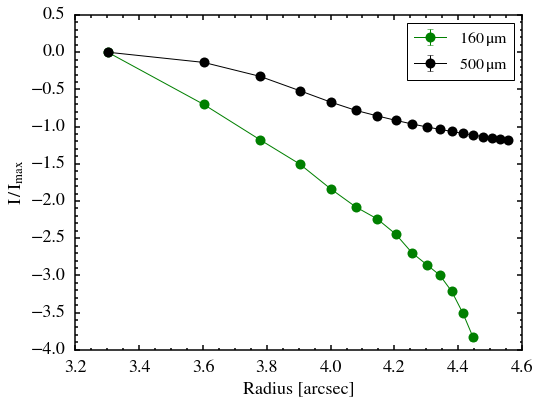

In [10]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

label = [r'$\rm{160\,\mu m}$', r'$\rm{500\,\mu m}$']
color = ['g','k']

for i in range(len(I_data)):
    I = I_data[i]
    I_err = I_err_data[i]
    r = r_data[i]
    
    I_hi = np.log10((I+I_err)/I.max())-np.log10(I/I.max())
    I_low = np.log10(I/I.max())-np.log10((I-I_err)/I.max())

    ax.errorbar(np.log10(r[:-1]*dstar), np.log10(I/I.max()),
                    yerr=(I_low, I_hi), color=color[i], marker='o', linestyle='-', 
                    mec='None', markersize=10, label=label[i])
    
    # assign 500 um data
    if i == 1:
        I_500 = I
        I_err_500 = I_err

# ax.legend([i], [r'$\rm{500\,\mu m}$'], fontsize=16, numpoints=1, loc='upper right')
ax.legend(fontsize=16, numpoints=1, loc='upper right')
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('Radius [arcsec]', fontsize=18)
ax.set_ylabel(r'$\rm{I\,/\,I_{max}}$', fontsize=18)

fig.savefig('/Users/yaolun/test/radial_profile_160_500.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Try to with some power law profiles

[[  9.26954901e-04  -2.42291270e-04]
 [ -2.42291270e-04   6.35578238e-05]]


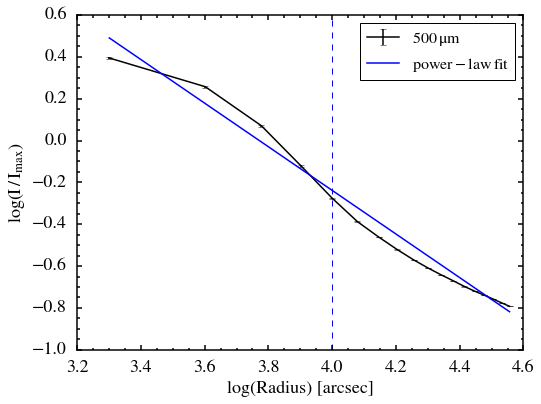

In [24]:
# where to fit?
r_max = 1e4 # AU
ind = r[:-1]*dstar <= r_max

from scipy import optimize

# log the data
logx = np.log10(r[:-1]*dstar)
logy = np.log10(I_500)
# take the square root of the large error * the small error as the uncertainty
logyerr = ((np.log10((I_500+I_err_500)/I.max())-np.log10(I_500/I_500.max())) *\
           (np.log10(I_500/I_500.max())-np.log10((I_500-I_err_500)/I_500.max())))**0.5

logx_fit = logx[ind]
logy_fit = logy[ind]
logyerr_fit = logyerr[ind]

# fitting functions
fitfunc = lambda p, x: p[0] + p[1] * x   
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

# initial guess
guess = [8.0, -1]
fit = optimize.leastsq(errfunc, guess, args=(logx_fit, logy_fit, logyerr_fit), full_output=1)

params = fit[0]
covar = fit[1]

yfit = params[0]+params[1]*logx
yerr = covar[0][0]+2*covar[0][1]*logx+covar[1][1]*logx**2

print covar

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

data = ax.errorbar(logx, logy, yerr=logyerr, color='k', marker='+', linestyle='-', mec='None', linewidth=1.5)
best_fit, = ax.plot(logx, yfit, color='b', linewidth=1.5)
ax.fill_between(logx, yfit-yerr, yfit+yerr, facecolor='b', edgecolor='None', alpha=0.5)
ax.axvline(np.log10(r_max), linestyle='--')

ax.legend([data, best_fit], [r'$\rm{500\,\mu m}$', r'$\rm{power-law\,fit}$'], 
          fontsize=16, numpoints=1, loc='upper right')
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('log(Radius) [arcsec]', fontsize=18)
ax.set_ylabel(r'$\rm{log(I\,/\,I_{max})}$', fontsize=18)

## Do the same thing for simulations

In [26]:
# read in from RTout
rtout = ModelOutput('/Users/yaolun/bhr71/hyperion/model79.rtout')
# setting up parameters
dstar = 200.
group = 8
wave = 500.0

im = rtout.get_image(group=group, inclination=0, distance=dstar*pc, units='Jy', uncertainties=True)

# Find the closest wavelength
iwav = np.argmin(np.abs(wave - im.wav))
# avoid zero when log, and flip the image
val = im.val[::-1, :, iwav]
unc = im.unc[::-1, :, iwav]

w = np.degrees(max(rtout.get_quantities().r_wall) / im.distance) * 3600
npix = len(val[:,0])
pix2arcsec = 2*w/npix

In [27]:
# radial grid in arcsec
annulus_width = 10
r = np.arange(10, 200, annulus_width, dtype=float)
I_sim = np.empty_like(r[:-1])
I_sim_err = np.empty_like(r[:-1])

# iteration
for ir in range(len(r)-1):
    aperture = CircularAnnulus((npix/2.+0.5, npix/2.+0.5), r_in=r[ir]/pix2arcsec, r_out=r[ir+1]/pix2arcsec)
#     print aperture.r_in
    phot = ap(val, aperture, error=unc)
    I_sim[ir] = phot['aperture_sum'].data / aperture.area()
    I_sim_err[ir] = phot['aperture_sum_err'].data / aperture.area()
    print r[ir], I_sim[ir], I_sim_err[ir]

10.0 0.0192045250653 0.000140686423389
20.0 0.00772385820155 5.5631678551e-05
30.0 0.00418982759267 3.01021029927e-05
40.0 0.00257119782093 1.86253584826e-05
50.0 0.0017258190162 1.26248912083e-05
60.0 0.0012330184434 9.13013958104e-06
70.0 0.000903474948073 6.83042164788e-06
80.0 0.000692096002152 5.3163526466e-06
90.0 0.000532877127184 4.2024597024e-06
100.0 0.000418728066609 3.40071130681e-06
110.0 0.000329976623016 2.78093786614e-06
120.0 0.000268639272871 2.33508633957e-06
130.0 0.000215374411789 1.95905891109e-06
140.0 0.000172945811184 1.6641609564e-06
150.0 0.00013887850704 1.42741681588e-06
160.0 0.000110133496382 1.22757216814e-06
170.0 8.39746424616e-05 1.03390069447e-06
180.0 5.90581889727e-05 8.2185722479e-07


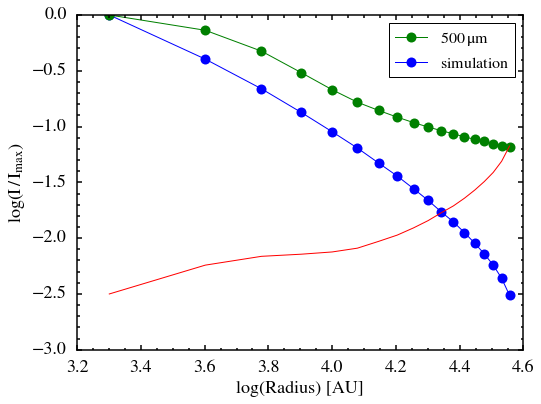

In [29]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

i_sim, = ax.plot(np.log10(r[:-1]*dstar), np.log10(I_sim/I_sim.max()), 'o-', mec='None', markersize=10)
i, = ax.plot(np.log10(r[:-1]*dstar), np.log10(I/I.max()), 'o-', mec='None', markersize=10)

ax.plot(np.log10(r[:-1]*dstar), np.log10(I/I.max())-np.log10(I_sim/I_sim.max())-2.5)

ax.legend([i, i_sim], [r'$\rm{500\,\mu m}$', r'$\rm{simulation}$'], fontsize=16, numpoints=1, loc='upper right')
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('log(Radius) [AU]', fontsize=18)
ax.set_ylabel(r'$\rm{log(I\,/\,I_{max})}$', fontsize=18)